## Mô tả dữ liệu

File dữ liệu chúng ta đang xét gồm có các thuộc tính:
- `age`: Tuổi của những người trong bảng dữ liệu này (đều là những người phụ thuộc chính).
- `sex`: Giới tính của những người này, gồm hai giá trị: male và female.
- `bmi`: Chỉ số BMI của những người này.
- `children`: Số lượng con/số lượng người phụ thuộc.
- `smoker`: Người đó có hút thuốc (yes) hay không hút thuốc (no).
- `region`: Khu vực sinh sống ở Mỹ: northeast, southeast, southwest, northwest.
- `charges`: Mức viện phí được chi trả bởi Bảo hiểm Y tế. 

## Import các thư viện

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(style = "darkgrid")
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Ridge

## Bước 1: Lấy dữ liệu và kiểm tra

Lấy dữ liệu bằng thư viện `pandas`

In [2]:
df = pd.read_csv('insurance.csv')

Loại bỏ dữ liệu trùng lắp

In [3]:
df.drop_duplicates()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Lấy thông tin về dữ liệu

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Kiểm tra dữ liệu có bị mất không

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Bước 2. Phân tích dữ liệu

Lấy 10 dòng dữ liệu đầu để quan sát các giá trị

In [6]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Đếm giá trị trong cột `sex`

In [7]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

Đếm giá trị trong cột `region`

In [8]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Đối với cột `children`, ta đưa cột này về dạng `object` và đếm các giá trị trong cột này

In [9]:
df['children'] = df['children'].astype('object')
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

Vẽ biểu đồ cột so sánh tổng mức chi trả viện phí tương ứng ở mỗi khu vực.

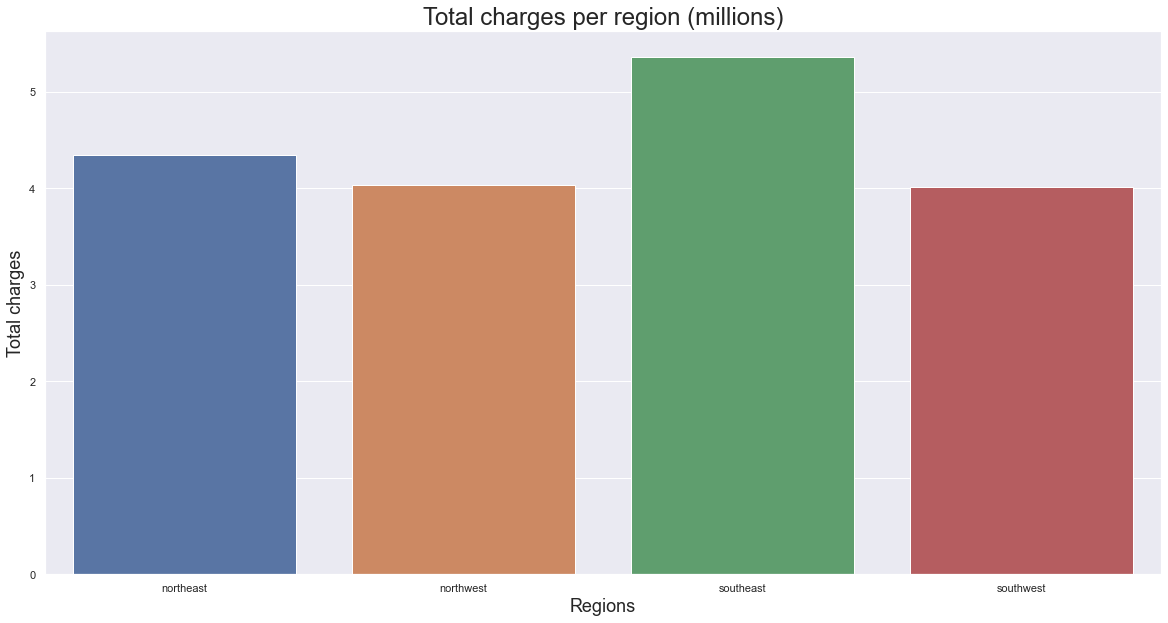

In [10]:
region_cost = df.groupby('region')['charges'].sum() * 1e-6
fig = plt.figure(figsize=(20, 10))
sns.barplot(region_cost.index, region_cost.values)
plt.title("Total charges per region (millions)", size=24)
plt.xlabel('Regions', size=18)
plt.ylabel('Total charges', size=18)
plt.show()

Từ biểu đồ trên, khu vực southeast có tổng mức chi trả viện phí cao nhất, 3 khu vực còn lại có tổng mức chi trả khá gần nhau.

Ta vẽ biểu đồ phân tán giữa mức tuổi và viện phí phải trả

Text(0.5, 1.0, 'Charges and Ages')

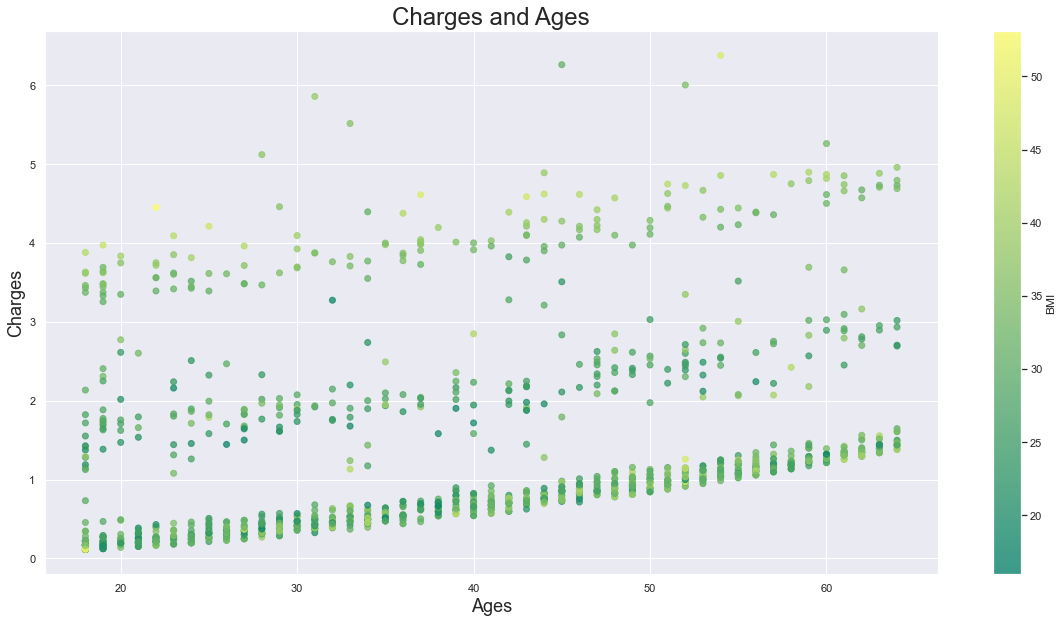

In [11]:
fig = plt.figure(figsize = (20, 10))
plt.scatter(df['age'], df['charges'] * 1e-4, cmap='summer', c=df['bmi'], alpha=0.75)
plt.xlabel('Ages', size=18)
plt.ylabel('Charges', size=18)
plt.colorbar(label='BMI')
plt.title('Charges and Ages', size=24)

Tổng viện phí phải trả ở những nhóm người lớn tuổi nhìn chung là lớn hơn so với nhóm tuổi nhỏ hơn. Tuy vậy, vẫn có một số cá thể ở nhóm tuổi thấp nhưng viện phí phải trả lại rất cao.

Đồ thị boxplot về chỉ số BMI

Text(0.5, 0, 'BMI')

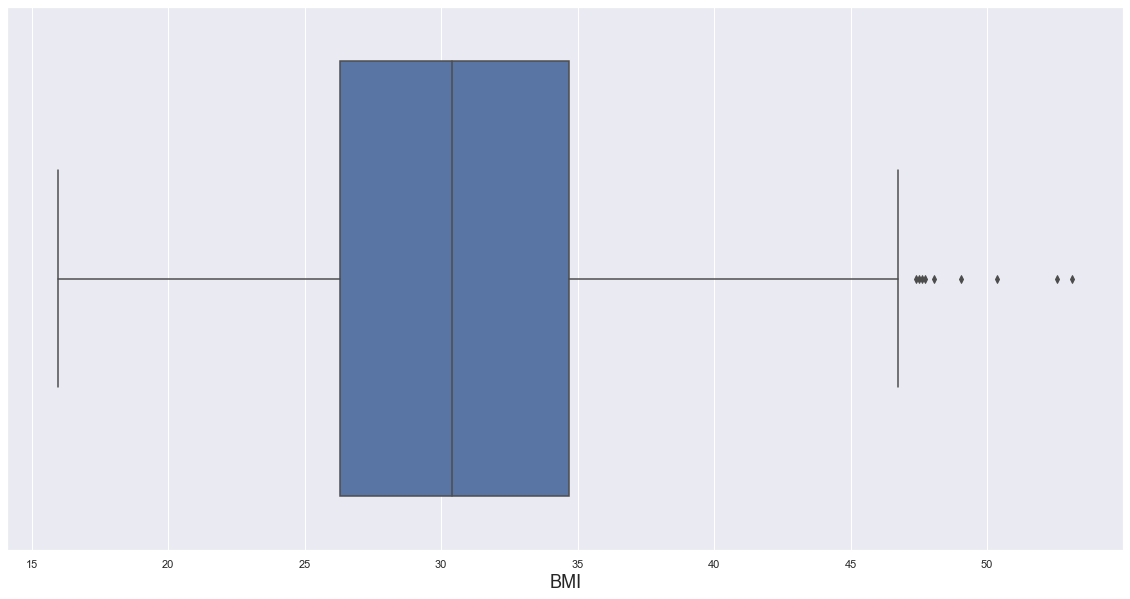

In [12]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(df['bmi'])
plt.xlabel('BMI', size=18)

Đồ thị boxplot về chỉ số viện phí phải trả

Text(0.5, 0, 'Charges')

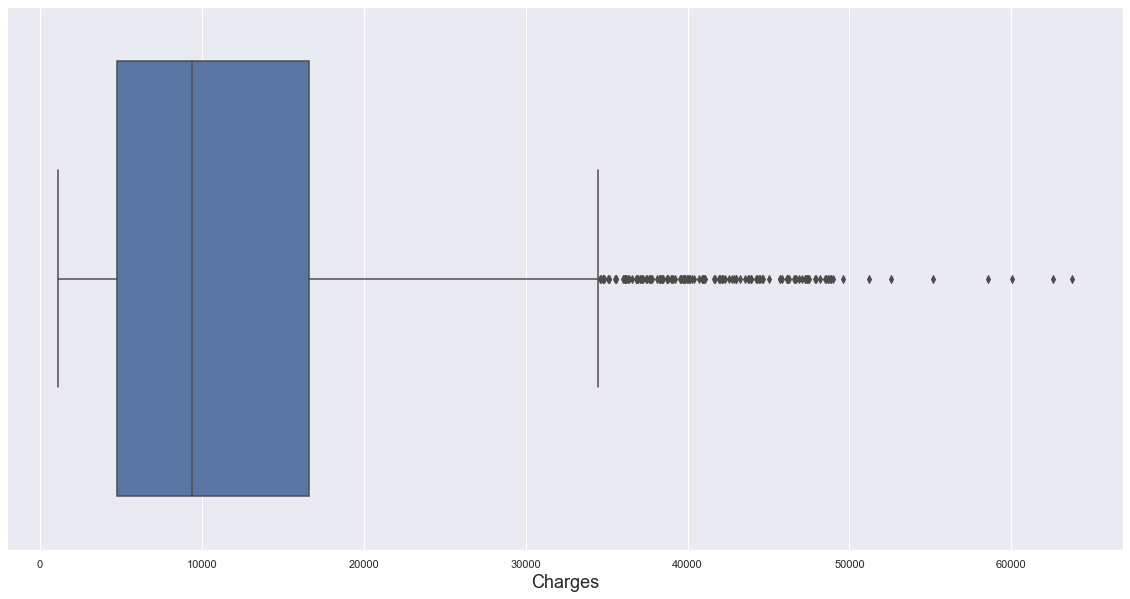

In [13]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(df['charges'])
plt.xlabel('Charges', size=18)

Loạ bỏ các điểm outliers.

In [14]:
df.drop(df.query('bmi > 50').index, 0, inplace=True)
df.drop(df.query('charges > 50000').index, 0, inplace=True)

Biểu đồ cột về mức viện phí được trả theo giới tính.

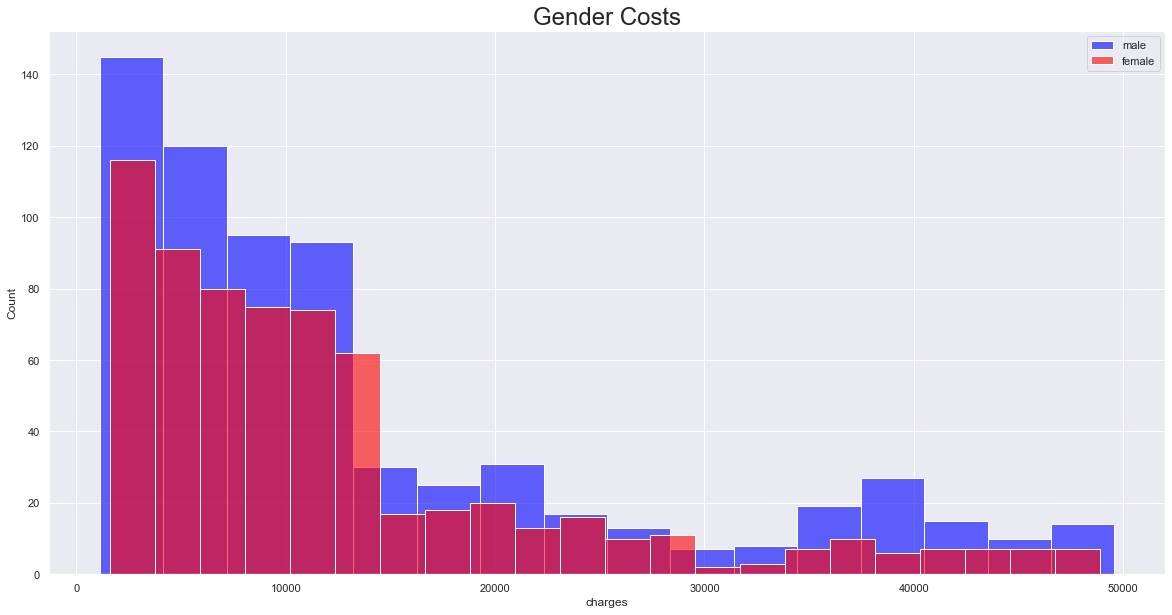

In [15]:
fig = plt.figure(figsize=(20, 10))
sns.histplot(data=df[df['sex']=='male'], x='charges', color='blue', label='male', alpha=0.6)
sns.histplot(data=df[df['sex']=='female'], x='charges', color='red', label='female', alpha=0.6)
plt.title('Gender Costs', size=24)
plt.legend()
plt.show()

Tổng viện phí chi trả cho những bệnh nhân nam cao hơn những bệnh nhân nữ

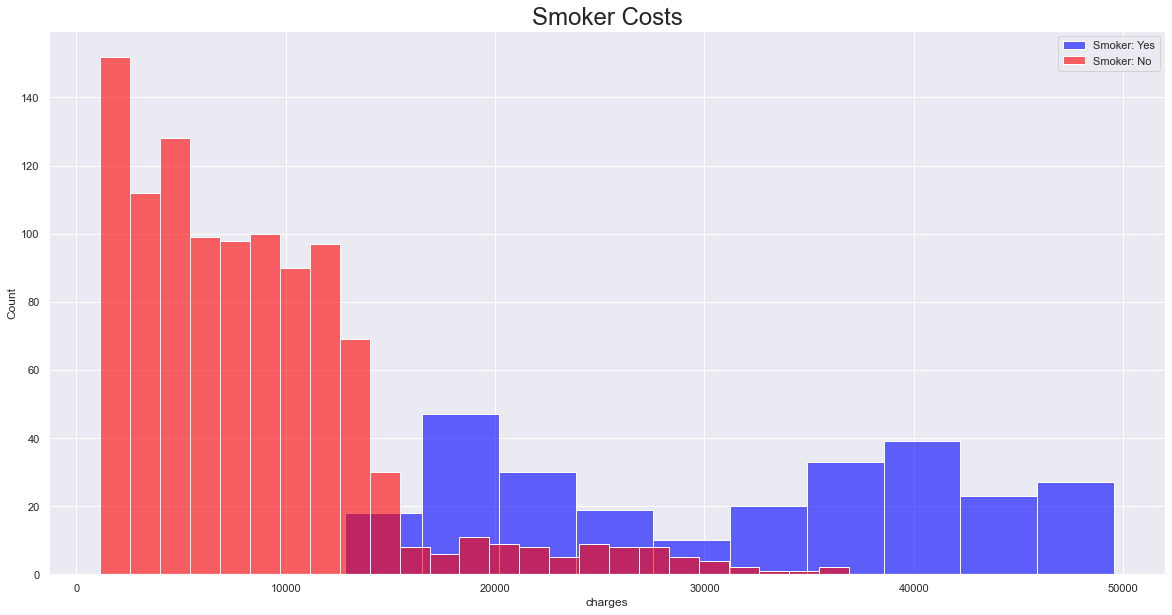

In [35]:
fig = plt.figure(figsize=(20, 10))
sns.histplot(data=df[df['smoker']=='yes'], x='charges', color='blue', label='Smoker: Yes', alpha=0.6)
sns.histplot(data=df[df['smoker']=='no'], x='charges', color='red', label='Smoker: No', alpha=0.6)
plt.title('Smoker Costs', size=24)
plt.legend()
plt.show()

Những bệnh nhân hút thuốc phải trả viện phí cao hơn những bệnh nhân không hút thuốc

In [17]:
df.drop_duplicates()
df.shape

(1328, 7)

## Bước 3: Tiền xử lý dữ liệu

Kiểm tra biến `charges` có tuân theo phân phối chuẩn hay không.

Text(0.5, 1.0, 'Probability Plot')

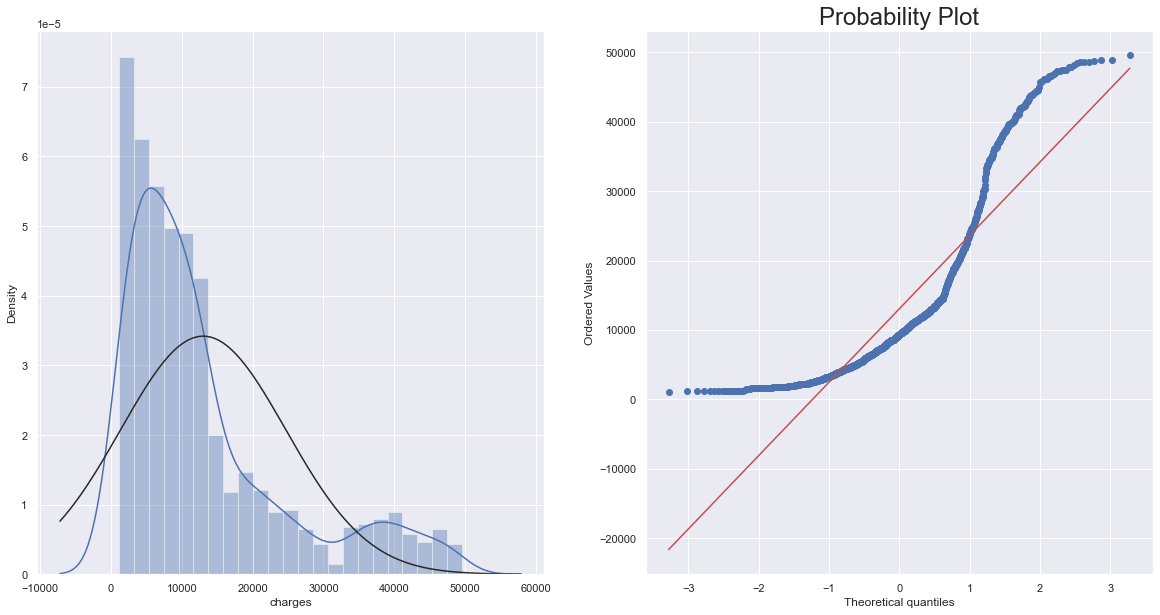

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(df['charges'], ax=ax[0], fit=stats.norm)
plt.title('Charges Distribution', size=24)
stats.probplot(df['charges'], plot=plt)
plt.title('Probability Plot', size=24)

Dữ liệu ban đầu chưa đạt phân phối chuẩn, vì vậy ta cần đưa nó về phân phối chuẩn bằng cách sử dụng hàm `np.log1p`

Text(0.5, 1.0, 'Probability Plot')

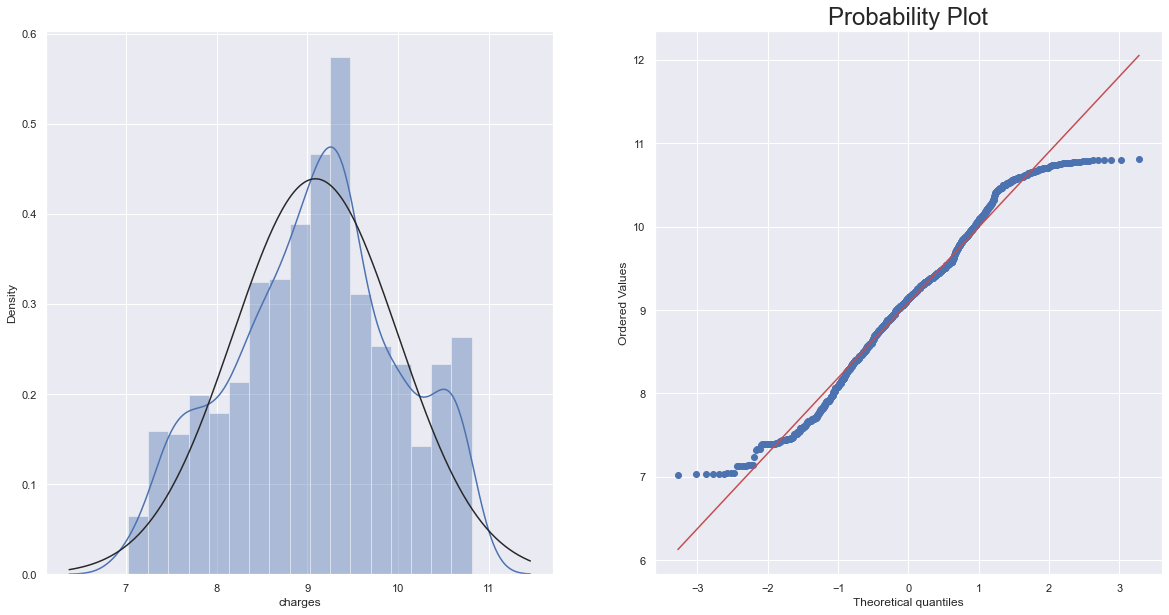

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
charges = np.log1p(df['charges'])
sns.distplot(charges, ax=ax[0], fit=stats.norm)
plt.title('Charges Distribution', size=24)
stats.probplot(charges, plot=plt)
plt.title('Probability Plot', size=24)

Như vậy sau phép biến đổi trên, dữ liệu của biến `charges` đã được đưa về phân phối chuẩn. Ta có thể bắt đầu xây dựng mô hình.

## Bước 4. Xây dựng mô hình.

Đầu tiên, ta cần chia bộ dữ liệu thành 2 tập training set và test set.

In [20]:
y = df['charges']
X = df.drop('charges', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True)

Sau đó, chúng ta sẽ xây dựng một Pipeline. Pipeline này gồm 3 bước:
- ColumnTransformer (CT): Ta sẽ biến đổi các cột sao cho chúng thuận tiện nhất cho việc chạy mô hình:
    - Đối với dữ liệu có kiểu `object`, ta dùng OneHotEncoder để biến đổi các giá trị nhân tố thành các cột riêng rẽ có giá trị 0 hoặc 1.
    - Đối với biến `bmi`, vì số liệu khá lớn, ta dùng StandardScaler() để chuẩn hoá các giá trị này về các giá trị tuân theo phân phối chuẩn $\mathcal{N}(0, 1)$.
- PolynomialFeatures (PF): Vì dữ liệu không có tính tuyến tính, ta có thể dùng PolynomialFeatures để đưa về dạng đa thức, giải quyết được vấn đề phi tuyến tính.
- TransformedTargetRegressor (TTR): Ta sẽ dùng Ridge() để học từ tập train và dự đoán trên tập test, trong đó biến mục tiêu được biến đổi bằng hàm `np.log1p` trước khi đưa vào mô hình, sau đó dùng hàm ngược của hàm này là hàm `np.expm1` để trả về giá trị dự đoán.

In [21]:
pipeline = Pipeline(
    [
    ("CT", ColumnTransformer(
            [
                ("OHE", OneHotEncoder(), df.select_dtypes('object').columns),
                ("SCL", StandardScaler(), ['bmi'])
            ],
            remainder = 'passthrough')),
    ("PF", PolynomialFeatures(2)),
    ("TTR", TransformedTargetRegressor(
            regressor=Ridge(), 
            func=np.log1p, 
            inverse_func=np.expm1))
    ]
)

Sau khi xây dựng được pipeline, ta cho pipeline này học và dự đoán dựa trên bộ dữ liệu chúng ta đang có. Chúng ta có thể tính được hệ số tương quan `r2_score` cũng như là tổng sai số bình phương `mean_squared_error` của mô hình.

In [22]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(r2_score(y_pred, y_test))
print(mean_squared_error(y_pred, y_test))

0.8302268935728061
23897986.55016795


Bây giờ ta sẽ đi tối ưu mô hình. Trước tiên ta lấy ra tên của các tham số trong pipeline.

In [23]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'CT', 'PF', 'TTR', 'CT__n_jobs', 'CT__remainder', 'CT__sparse_threshold', 'CT__transformer_weights', 'CT__transformers', 'CT__verbose', 'CT__OHE', 'CT__SCL', 'CT__OHE__categories', 'CT__OHE__drop', 'CT__OHE__dtype', 'CT__OHE__handle_unknown', 'CT__OHE__sparse', 'CT__SCL__copy', 'CT__SCL__with_mean', 'CT__SCL__with_std', 'PF__degree', 'PF__include_bias', 'PF__interaction_only', 'PF__order', 'TTR__check_inverse', 'TTR__func', 'TTR__inverse_func', 'TTR__regressor__alpha', 'TTR__regressor__copy_X', 'TTR__regressor__fit_intercept', 'TTR__regressor__max_iter', 'TTR__regressor__normalize', 'TTR__regressor__random_state', 'TTR__regressor__solver', 'TTR__regressor__tol', 'TTR__regressor', 'TTR__transformer'])

Ta xác định các tham số cần tối ưu.

In [24]:
grid_params = {
    'PF__degree': [1, 2, 3],
    'TTR__regressor__alpha': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5]
}

Mục tiêu của chúng ta là làm cho tổng sai số bình phương bé nhất, vì vậy ta cần thiết lập thông số sao cho tổng bình phương càng bé càng tốt

In [25]:
MSE = make_scorer(mean_squared_error, greater_is_better=False)

Bây giờ ta tiến hành xác định các hệ số tối ưu nhất bằng GridSearchCV

In [26]:
grid_model = GridSearchCV(pipeline, grid_params, scoring = MSE)
grid_model.fit(X_train, y_train)
grid_model.best_params_

{'PF__degree': 2, 'TTR__regressor__alpha': 5}

Cuối cùng, ta chạy lại mô hình được tối ưu này.

In [27]:
grid_model.fit(X_train, y_train)
y_pred = grid_model.predict(X_test)
print(r2_score(y_pred, y_test))
print(mean_squared_error(y_pred, y_test))

0.8295744851176938
23869672.994687937
